# Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import talib as ta #TA-Lib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle
%matplotlib inline

In [2]:
#lendo o arquivo csv
df = pd.read_csv("EURUSD_Candlestick_1_D_BID_31.08.2018-30.12.2020.csv")


In [3]:
#arrumando a coluna gmt time para ficar só com o time e retirar a hora
from datetime import datetime
for i in range(len(df)):
    df['Gmt time'][i] = datetime.strptime(df['Gmt time'][i], '%d.%m.%Y %H:%M:%S.%f').strftime('%Y-%m-%d')

   

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [4]:
df.set_index('Gmt time', inplace = True)

In [5]:
df = df.drop_duplicates()

# calculando features e organizando os dados no dataframe

In [8]:
df['body'] = (df['Close']-df['Open'])*10000
df['pavio_sup'] = (df['High']-df['Open'])*10000
df['pavio_inf'] = (df['Close']-df['Low'])*10000


In [9]:
df.loc[df['body']>0, 'pavio_sup']=(df['High'][df['body']>0]-df['Close'][df['body']>0])*10000
df.loc[df['body']>0, 'pavio_inf']=(df['Open'][df['body']>0]-df['Low'][df['body']>0])*10000

In [10]:
df['SMA_50'] = ta.SMA(np.array(df['Close']),timeperiod=50)
df['SMA_20'] = ta.SMA(np.array(df['Close']), timeperiod=20)
df['ATR'] = ta.ATR(np.array(df['High']),np.array(df['Low']),np.array(df['Close']),timeperiod=50)
df['CCI'] = ta.CCI(np.array(df['High']),np.array(df['Low']),np.array(df['Close']),timeperiod=20)
df['SAR'] = ta.SAR(np.array(df['High']),np.array(df['Low']))

In [11]:
for i in np.arange(1,97):
    df['return_'+str(i)]=df['Close'].pct_change(i)
    df['lag_return_'+str(i)]=df['return_1'].shift(i)

In [12]:
df.loc[:,'sobe_desce']=-1 
df.loc[df['return_1'].shift(-1)>0,'sobe_desce']=1 
df = df.drop(columns=['return_1']) 

In [13]:
df = df.dropna(axis=0, how='any')

In [14]:
df

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-23,1.13692,1.14384,1.13604,1.13988,373047.2295,29.6,39.6,8.8,1.135974,1.135724,...,-0.006083,-0.019264,-0.000559,-0.019812,0.004205,-0.015690,-0.003236,-0.018876,0.001586,-1
2018-12-24,1.13976,1.14170,1.13894,1.13988,8155.2801,1.2,18.2,8.2,1.135967,1.136136,...,0.000000,-0.013262,-0.006083,-0.019264,-0.000559,-0.019812,0.004205,-0.015690,-0.003236,-1
2018-12-25,1.13901,1.14198,1.13428,1.13507,257461.1485,-39.4,29.7,7.9,1.135924,1.136126,...,0.003497,-0.017426,0.000000,-0.017426,-0.006083,-0.023402,-0.000559,-0.023948,0.004205,1
2018-12-26,1.13507,1.14540,1.13504,1.14285,563907.8267,77.8,25.5,0.3,1.136094,1.136561,...,0.001052,-0.014139,0.003497,-0.010691,0.000000,-0.010691,-0.006083,-0.016709,-0.000559,1
2018-12-27,1.14285,1.14727,1.14247,1.14414,453409.8906,12.9,31.3,3.8,1.136354,1.137046,...,0.001784,-0.014063,0.001052,-0.013026,0.003497,-0.009574,0.000000,-0.009574,-0.006083,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.21860,1.22502,1.21811,1.22160,140335.2883,30.0,34.2,4.9,1.199151,1.217060,...,0.002598,0.033975,0.001025,0.035035,0.002446,0.037567,-0.003352,0.034089,-0.002011,1
2020-12-28,1.22160,1.22750,1.22073,1.22478,152064.8677,31.8,27.2,8.7,1.200360,1.217698,...,0.000000,0.033980,0.002598,0.036666,0.001025,0.037729,0.002446,0.040268,-0.003352,1
2020-12-29,1.22455,1.23101,1.22453,1.22952,158740.0552,49.7,14.9,0.2,1.201670,1.218628,...,0.001604,0.037981,0.000000,0.037981,0.002598,0.040678,0.001025,0.041745,0.002446,-1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 635 entries, 2018-12-23 to 2020-12-31
Columns: 205 entries, Open to sobe_desce
dtypes: float64(204), int64(1)
memory usage: 1022.0+ KB


In [16]:
df =df.iloc[8:]

In [17]:
df.head(100)

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1.14598,1.14967,1.13250,1.13432,444066.5465,-116.6,36.9,18.2,1.136605,1.138211,...,0.005188,-0.024048,0.000000,-0.024048,-0.005732,-0.029641,0.005540,-0.024266,0.001784,1
2019-01-02,1.13423,1.14110,1.13092,1.13924,503259.7333,50.1,18.6,33.1,1.136537,1.138596,...,-0.001532,-0.024874,0.005188,-0.019815,0.000000,-0.019815,-0.005732,-0.025433,0.005540,1
2019-01-03,1.13924,1.14189,1.13456,1.13943,418205.8579,1.9,24.6,46.8,1.136476,1.138727,...,0.000600,-0.023215,-0.001532,-0.024711,0.005188,-0.019651,0.000000,-0.019651,-0.005732,-1
2019-01-04,1.13943,1.13943,1.13943,1.13943,0.0000,0.0,0.0,0.0,1.136538,1.138918,...,0.008953,-0.023800,0.000600,-0.023215,-0.001532,-0.024711,0.005188,-0.019651,0.000000,1
2019-01-06,1.13955,1.14826,1.13954,1.14740,365290.1607,78.5,8.6,0.1,1.136818,1.139766,...,-0.002488,-0.025695,0.008953,-0.016972,0.000600,-0.016382,-0.001532,-0.017889,0.005188,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-22,1.12568,1.12612,1.11921,1.12268,362754.9433,-30.0,4.4,34.7,1.128384,1.125048,...,0.000000,-0.014700,0.000167,-0.014536,0.004337,-0.010262,-0.010425,-0.020580,-0.000148,-1
2019-04-23,1.12264,1.12265,1.11406,1.11519,392251.1006,-74.5,0.1,11.3,1.127974,1.124746,...,0.006995,-0.021274,0.000000,-0.021274,0.000167,-0.021111,0.004337,-0.016865,-0.010425,-1
2019-04-24,1.11518,1.11623,1.11178,1.11309,351084.3925,-20.9,10.5,13.1,1.127459,1.124381,...,-0.002911,-0.029902,0.006995,-0.023117,0.000000,-0.023117,0.000167,-0.022954,0.004337,1


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 627 entries, 2019-01-01 to 2020-12-31
Columns: 205 entries, Open to sobe_desce
dtypes: float64(204), int64(1)
memory usage: 1009.1+ KB


# definindo o tamanho total da amostra para trabalhar


In [69]:
#definindo o tamanho da amostra
amostra = df.iloc[:600]

In [70]:
amostra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 2019-01-01 to 2020-11-30
Columns: 205 entries, Open to sobe_desce
dtypes: float64(204), int64(1)
memory usage: 965.6+ KB


In [71]:
amostra.head()

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1.14598,1.14967,1.13250,1.13432,444066.5465,-116.6,36.9,18.2,1.136605,1.138211,...,0.005188,-0.024048,0.000000,-0.024048,-0.005732,-0.029641,0.005540,-0.024266,0.001784,1
2019-01-02,1.13423,1.14110,1.13092,1.13924,503259.7333,50.1,18.6,33.1,1.136537,1.138596,...,-0.001532,-0.024874,0.005188,-0.019815,0.000000,-0.019815,-0.005732,-0.025433,0.005540,1
2019-01-03,1.13924,1.14189,1.13456,1.13943,418205.8579,1.9,24.6,46.8,1.136476,1.138727,...,0.000600,-0.023215,-0.001532,-0.024711,0.005188,-0.019651,0.000000,-0.019651,-0.005732,-1
2019-01-04,1.13943,1.13943,1.13943,1.13943,0.0000,0.0,0.0,0.0,1.136538,1.138918,...,0.008953,-0.023800,0.000600,-0.023215,-0.001532,-0.024711,0.005188,-0.019651,0.000000,1
2019-01-06,1.13955,1.14826,1.13954,1.14740,365290.1607,78.5,8.6,0.1,1.136818,1.139766,...,-0.002488,-0.025695,0.008953,-0.016972,0.000600,-0.016382,-0.001532,-0.017889,0.005188,-1


# definindo o tamanho da janela


In [90]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

#  faz-se o tuning utilizando o grid_search para rodar o random forest sem a tunagem a cada passo


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
# Cria a matriz de parâmetros 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70, 80, 90 , 100, 110],
    'max_features': [2 ,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5, 6, 7, 8, 9, 10, 11],
    'n_estimators': [ 200, 300, 400, 500, 600],
    'random_state':[0,42]
}
# define o mdelo
rf = RandomForestClassifier()
# instanciando grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [24]:
for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #troca o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    #usa o grid para procurar os melhores hyperparametros
 
    grid_search.fit(X_treino, Y_treino)
    yrf_pred=grid_search.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)

    
    
    window= window+60
    print(grid_search.best_params_)
    print(acuracia)

Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 46.6min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 55.8min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 67.1min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300, 'random_state': 42}
0.5333333333333333
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 45.4min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 51.6min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 58.6min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 67.9min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 600, 'random_state': 0}
0.6
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 50.7min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}
0.5833333333333334
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 37.0min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}
0.5
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 50.3min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 200, 'random_state': 42}
0.5666666666666667
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 400, 'random_state': 42}
0.55


# agora pegando os parametros que apresentaram uma maior acurácia no grid_search , faz-se o walkforward com eles

In [91]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
rf = RandomForestClassifier(random_state= 0,bootstrap = True, max_depth = 50, max_features= 3, min_samples_leaf = 3, min_samples_split= 10, n_estimators = 200)


In [93]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]


In [94]:
for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #trocar o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    
    #faz a predição e coleta o valor
    rf.fit(X_treino,Y_treino)
    yrf_pred=rf.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)
    pontos.extend(X_teste['body'])
    predicoes.extend(yrf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    window= window+60
    
    print(acuracia)
# 0.5333333333333333
# 0.5833333333333334
# 0.6166666666666667
# 0.5
# 0.6
# 0.55

0.5333333333333333
0.6166666666666667
0.6333333333333333
0.5
0.45
0.5333333333333333


# implementando a estratégia:

# defini de uma forma bem simples que o ganho/perda do dia seria a diferença de abertura - fechamento da vela
# se o valor predito fosse igual ao valor real da ordem ( 1 -> compra ; -1 -> venda), ele somaria os pips ao saldo caso estivesse correto ou subtrairia caso estivesse errado.



In [95]:
saldo = 1000


In [96]:
lucro = pd.DataFrame(dias)

In [97]:
lucro.columns=['Data']

In [98]:
lucro.set_index('Data', inplace = True)

In [99]:
lucro.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)

In [100]:
lucro.head()

,Saldo
Data,
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000
2019-10-13,1000


In [101]:
saldo

1000

In [102]:
for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs(pontos[i]*0.1)
        lucro.iloc[i] = saldo
         
    else:
        saldo = saldo - abs(pontos[i]*0.1)
        lucro.iloc[i] = saldo     
       
    
#     print(saldo)

In [103]:
lucro

,Saldo
Data,
2019-10-08,1000.00
2019-10-09,996.54
2019-10-10,999.34
2019-10-11,999.34
2019-10-13,998.66
...,...
2020-11-25,1212.93
2020-11-26,1217.88
2020-11-27,1217.88


In [104]:
lucro['Retorno']=lucro['Saldo'].pct_change()

In [105]:
lucro['R. Acumulado'] = (1+lucro['Retorno']).cumprod()

In [106]:
lucro['Retorno'].iloc[0] = 0
lucro['R. Acumulado'].iloc[0]=0

In [107]:
lucro.head()

,Saldo,Retorno,R. Acumulado
Data,,,
2019-10-08,1000.00,0.00000,0.00000
2019-10-09,996.54,-0.00346,0.99654
2019-10-10,999.34,0.00281,0.99934
2019-10-11,999.34,0.00000,0.99934
2019-10-13,998.66,-0.00068,0.99866


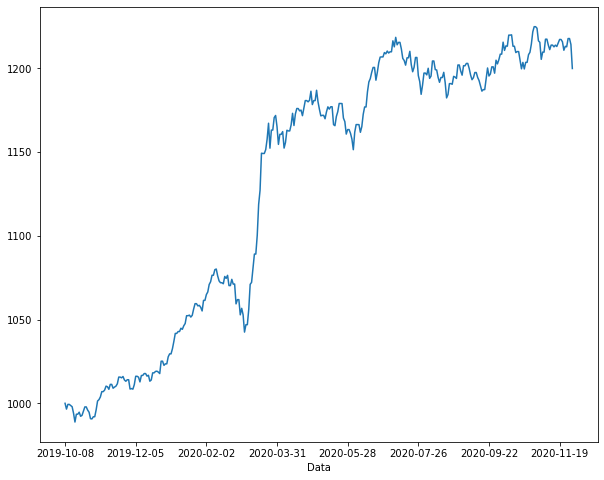

In [52]:
lucro['Saldo'].plot(figsize=(10,8))

In [53]:
lucro.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

# Métricas de desempenho


# Índice de Sharpe


In [54]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio1 = (lucro['Retorno'].mean()*(255-0.01) )/(lucro['Retorno'].std()*np.sqrt(255)) # mean = return_series.mean() * N -rf
print(Sharpe_Ratio1)

2.100069234736132


# Retorno anualizado

In [55]:
Retorno_anualizado1 = (1+lucro['Retorno'].sum())**0.5

In [56]:
print(Retorno_anualizado1)

1.0886189989679758


# Máximo Drawdown

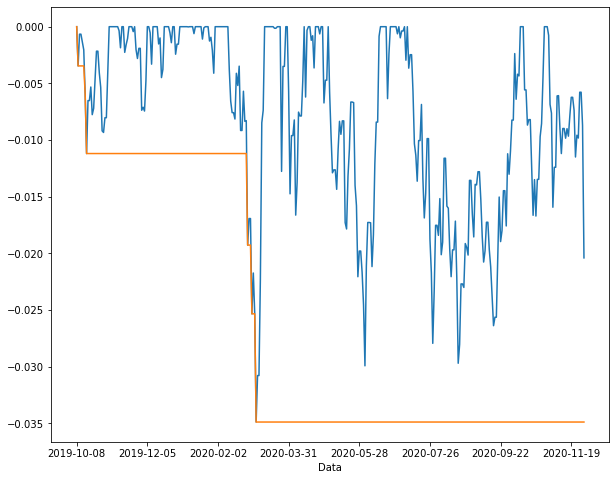

In [57]:
Roll_Max1 = lucro['Saldo'].cummax()
Daily_Drawdown1 = lucro['Saldo']/Roll_Max1 - 1.0
MDD1 = Daily_Drawdown1.cummin()
# Plotando o resultado
Daily_Drawdown1.plot(figsize =(10,8))
MDD1.plot(figsize=(10,8))

In [58]:
MDD1.min()

-0.03487317163488313

# Índice de Calmar

In [59]:
Calmar_Ratio1 = (-lucro['Retorno'].mean()*255)/MDD1.min()
print(Calmar_Ratio1)

3.7595191088469786


# Calculando o walkforward com o grid_search a cada passo

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
# cria matriz de parametros
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 50, 60],
    'max_features': [2 ,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5, 6, 7, 8, 9, 10, 11],
    'n_estimators': [ 200, 300, 400, 500, 600],
    'random_state': [0, 42]
}
# cria a base do modelo
rf = RandomForestClassifier()
# Instanciando o modelo do grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [23]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [24]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #troca o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    #faz a predição e coleta o valor
   
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_treino, Y_treino)
    yrf_pred=grid_search.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)

    pontos.extend(X_teste['body'])
    predicoes.extend(yrf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    
    window= window+60
    print(acuracia)

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 24.5min finished


0.5333333333333333
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 22.3min finished


0.6
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 23.7min finished


0.5833333333333334
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 21.6min finished


0.5
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 21.2min finished


0.5666666666666667
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 24.4min finished


0.55


# Calculando retornos com WFA com grid search a cada passo

In [25]:
saldo = 1000


In [26]:
lucroWFA = pd.DataFrame(dias)
lucroWFA.columns=['Data']
lucroWFA.set_index('Data', inplace = True)
lucroWFA.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
lucroWFA.head()

,Saldo
Data,
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000
2019-10-13,1000


In [27]:
for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs(pontos[i]*0.1)
        lucroWFA.iloc[i] = saldo
         
    else:
        saldo = saldo - abs(pontos[i]*0.1)
        lucroWFA.iloc[i] = saldo  

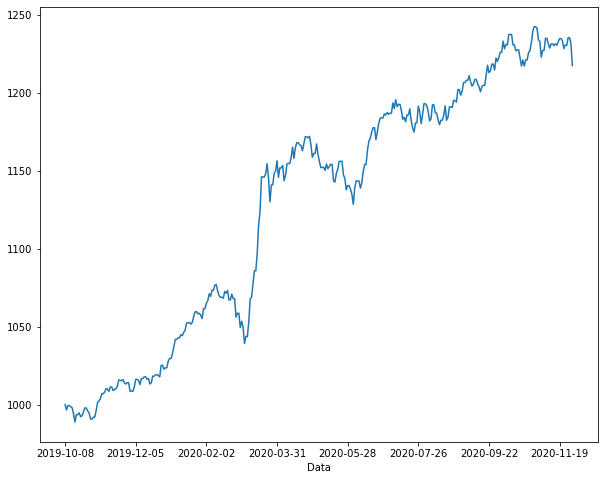

In [28]:
lucroWFA['Retorno']=lucroWFA['Saldo'].pct_change()
lucroWFA['R. Acumulado'] = (1+lucroWFA['Retorno']).cumprod()
lucroWFA['Retorno'].iloc[0] = 0
lucroWFA['R. Acumulado'].iloc[0]=0
lucroWFA['Saldo'].plot(figsize=(10,8))

In [29]:
lucroWFA.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

In [30]:
lucroWFA

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-08,-1,1000.00,0.000000,0.00000
2019-10-09,-1,996.54,-0.003460,0.99654
2019-10-10,-1,999.34,0.002810,0.99934
2019-10-11,-1,999.34,0.000000,0.99934
2019-10-13,-1,998.66,-0.000680,0.99866
...,...,...,...,...
2020-11-25,-1,1230.17,-0.000244,1.23017
2020-11-26,-1,1235.12,0.004024,1.23512
2020-11-27,-1,1235.12,0.000000,1.23512


# Métricas de desempenho


# Índice de Sharpe

In [31]:
lucroWFA['Retorno']=lucroWFA['Saldo'].pct_change()
lucroWFA['R. Acumulado'] = (1+lucroWFA['Retorno']).cumprod()
lucroWFA['Retorno'].iloc[0] = 0
lucroWFA['R. Acumulado'].iloc[0]=0

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio2 = (lucroWFA['Retorno'].mean()*(255-0.01))/(lucroWFA['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio2)

2.254040240167144


# Retorno anualizado

In [33]:
Retorno_anualizado2 = (1+lucroWFA['Retorno'].sum())**0.5
print(Retorno_anualizado2)

1.0951635964307989


# Máximo Drawdown

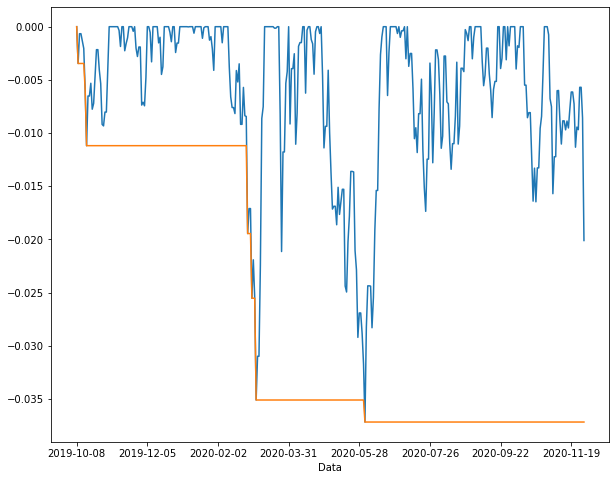

In [34]:
Roll_Max2 = lucroWFA['Saldo'].cummax()
Daily_Drawdown2 = lucroWFA['Saldo']/Roll_Max2 - 1.0
MDD2 = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDD2.plot(figsize=(10,8))

In [32]:
MDD2.min()

-0.03717925743883843

# Índice de Calmar

In [33]:
Calmar_Ratio2 = (-lucroWFA['Retorno'].mean()*255)/MDD2.min()
print(Calmar_Ratio2)

3.7986191580065594


In [34]:
lucroWFA

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-08,-1,1000.00,0.000000,0.00000
2019-10-09,-1,996.54,-0.003460,0.99654
2019-10-10,-1,999.34,0.002810,0.99934
2019-10-11,-1,999.34,0.000000,0.99934
2019-10-13,-1,998.66,-0.000680,0.99866
...,...,...,...,...
2020-11-25,-1,1230.17,-0.000244,1.23017
2020-11-26,-1,1235.12,0.004024,1.23512
2020-11-27,-1,1235.12,0.000000,1.23512


# Fazendo benchmark com cruzamento de médias móveis

In [35]:
amostrasma=amostra


In [36]:
amostrasma['price yesterday'] = amostrasma['Close'].shift(1)
amostrasma['change'] = (amostrasma['Close']/amostrasma['price yesterday'])
# invested macd
amostrasma['invested_SMA'] = [1 if amostrasma.loc[i,'SMA_20'] > amostrasma.loc[i,'SMA_50'] else -1 for i in amostrasma.index]
SMA=amostrasma[amostrasma['invested_SMA']==1]
amostrasma['retorno']=np.cumprod(SMA['change'])


C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

# Separando os dias de operação conforme walkforward


In [37]:
janela = 240
total=amostrasma.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosSma=[]
diasSma=[]
close=[]
sinal=[]
SMA50=[]
SMA20=[]
yprice=[]
change=[]
invistedSMA=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostrasma.iloc[t:(janela)]
    inSample = amostrasma.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosSma.extend(inSample['body'])
    diasSma.extend(inSample.index)
    close.extend(inSample['Close'])
    
    SMA50.extend(inSample['SMA_50'])
    SMA20.extend(inSample['SMA_20'])
    yprice.extend(inSample['price yesterday'])
    change.extend(inSample['change'])
    invistedSMA.extend(inSample['invested_SMA'])
    retorno.extend(inSample['retorno'])
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [38]:
dfSMA = pd.DataFrame(diasSma)
dfSMA.columns=['Data']
dfSMA.set_index('Data', inplace = True)
dfSMA.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfSMA.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfSMA.insert(loc=2, column='SMA_50', value=SMA50, allow_duplicates=False)
dfSMA.insert(loc=3, column='SMA_20', value=SMA20, allow_duplicates=False)
dfSMA.insert(loc=4, column='yesterday price', value=yprice, allow_duplicates=False)
dfSMA.insert(loc=5, column='change', value=change, allow_duplicates=False)
dfSMA.insert(loc=6, column='retorno', value=retorno, allow_duplicates=False)
dfSMA.insert(loc=7, column='invisted sma', value=invistedSMA, allow_duplicates=False)

In [39]:
saldo=1000
for i in np.arange(1,len(diasSma)):
    if invistedSMA[i]==1:
        saldo=saldo +(dfSMA['Close'].iloc[i]-dfSMA['yesterday price'].iloc[i])*1000
        dfSMA['Saldo'].iloc[i]=saldo
    else:
        saldo=saldo + (dfSMA['yesterday price'].iloc[i]-dfSMA['Close'].iloc[i])*1000
        dfSMA['Saldo'].iloc[i]=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
dfSMA.head(30)

,Saldo,Close,SMA_50,SMA_20,yesterday price,change,retorno,invisted sma
Data,,,,,,,,
2019-10-08,1000.00,1.09710,1.102796,1.097616,1.09560,1.001369,NaN,-1
2019-10-09,996.60,1.10050,1.102464,1.097279,1.09710,1.003099,NaN,-1
2019-10-10,993.81,1.10329,1.102254,1.097294,1.10050,1.002535,NaN,-1
2019-10-11,993.81,1.10329,1.102107,1.097255,1.10329,1.000000,NaN,-1
2019-10-13,994.62,1.10248,1.101977,1.097294,1.10329,0.999266,NaN,-1
2019-10-14,993.90,1.10320,1.101861,1.097370,1.10248,1.000653,NaN,-1
2019-10-15,990.00,1.10710,1.101848,1.097762,1.10320,1.003535,NaN,-1
2019-10-16,984.76,1.11234,1.101895,1.098283,1.10710,1.004733,NaN,-1
2019-10-17,980.07,1.11703,1.102066,1.099428,1.11234,1.004216,NaN,-1


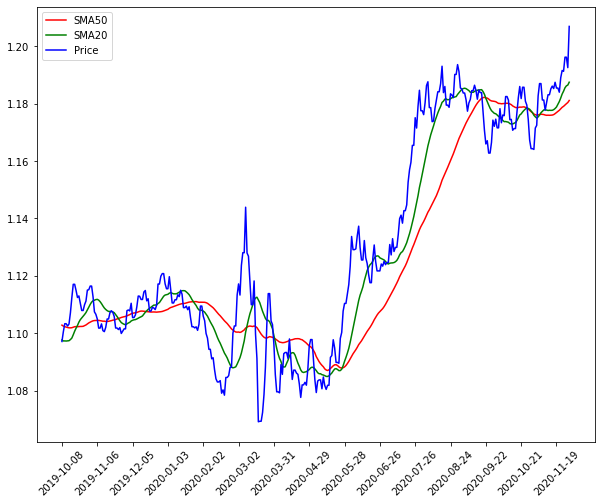

In [41]:
#plotando o gráfico
plt.figure(figsize = (10,8))
plt.plot(dfSMA.index, dfSMA['SMA_50'], label='SMA50', color = 'red')
plt.plot(dfSMA.index, dfSMA['SMA_20'], label = 'SMA20', color = 'green')
plt.plot(dfSMA.index, dfSMA['Close'],label='Price', color = 'blue')
plt.xticks(dfSMA.index[::25],rotation = 45)
plt.legend(loc='upper left')
plt.show()


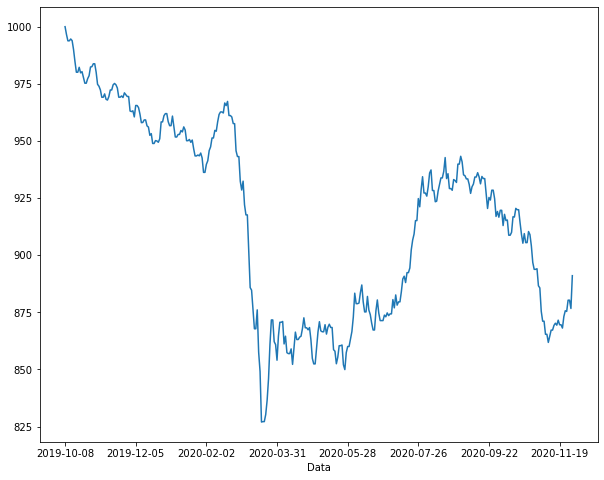

In [100]:
dfSMA['Saldo'].plot(figsize=(10,8))

# Métricas SMA


In [101]:
dfSMA['Retorno']=dfSMA['Saldo'].pct_change()
dfSMA['R. Acumulado'] = (1+dfSMA['Retorno']).cumprod()
dfSMA['Retorno'].iloc[0] = 0
dfSMA['R. Acumulado'].iloc[0]=0

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [102]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_SMA = (dfSMA['Retorno'].mean()*(255-0.01))/(dfSMA['Retorno'].std()*np.sqrt(255))
print(Sharpe_SMA)

-0.9684515408180268


In [103]:
#Retorno anualizado
Retorno_anualizadoSMA= (1+dfSMA['Retorno'].sum())**0.5
print(Retorno_anualizadoSMA)

0.9430158019545999


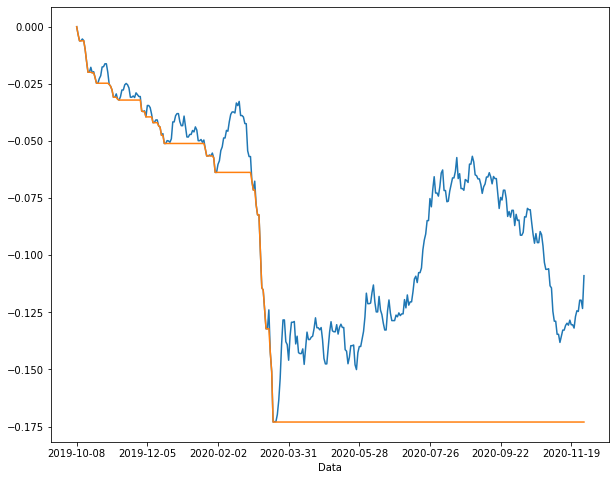

In [104]:
#MDD
Roll_Max2 = dfSMA['Saldo'].cummax()
Daily_Drawdown2 = dfSMA['Saldo']/Roll_Max2 - 1.0
MDDSMA = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDSMA.plot(figsize=(10,8))

In [105]:
MDDSMA.min()

-0.1730100000000001

In [106]:
#Calmar
Calmar_SMA = (-dfSMA['Retorno'].mean()*255)/MDDSMA.min()
print(Calmar_SMA)

-0.45331203241784834


# Benchmark ATR

In [42]:
amostraATR= amostra

In [43]:
janela = 240
total=amostraATR.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosAtr=[]
diasAtr=[]
close=[]
sinal=[]
ATR=[]
yprice=[]
change=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostraATR.iloc[t:(janela)]
    inSample = amostraATR.iloc[(janela):(janela+60)] 
    
      
    #coleta os valores nas janelas de operação
    pontosSma.extend(inSample['body'])
    diasAtr.extend(inSample.index)
    close.extend(inSample['Close'])
    ATR.extend(inSample['ATR'])
    
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [44]:
dfATR = pd.DataFrame(diasAtr)
dfATR.columns=['Data']
dfATR.set_index('Data', inplace = True)
dfATR.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfATR.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfATR.insert(loc=2, column='ATR', value=ATR, allow_duplicates=False)
dfATR.insert(loc=3, column ='flag',value = 0, allow_duplicates=False)
saldo=1000

In [45]:
saldo=1000
flag = 0
for i in np.arange(1,len(diasAtr)):
    
    if ATR[i]>0.009:
        flag = -1
        dfATR['flag'].iloc[i]= flag
    elif ATR[i] < 0.005:
        flag = 1
        dfATR['flag'].iloc[i]= flag

    if flag ==1:
        saldo=saldo + (dfATR['Close'].iloc[i]-dfATR['Close'].iloc[i-1])*1000
        dfATR['Saldo'].iloc[i]=saldo
    elif flag == -1:
        saldo=saldo + (dfATR['Close'].iloc[i-1]-dfATR['Close'].iloc[i])*1000
        dfATR['Saldo'].iloc[i]=saldo
    elif flag==0:
        saldo=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
dfATR

,Saldo,Close,ATR,flag
Data,,,,
2019-10-08,1000.00,1.09710,0.004851,0
2019-10-09,1003.40,1.10050,0.004881,1
2019-10-10,1006.19,1.10329,0.004907,1
2019-10-11,1006.19,1.10329,0.004809,1
2019-10-13,1005.38,1.10248,0.004773,1
...,...,...,...,...
2020-11-25,1094.17,1.19127,0.006438,0
2020-11-26,1099.10,1.19620,0.006424,0
2020-11-27,1099.10,1.19620,0.006295,0


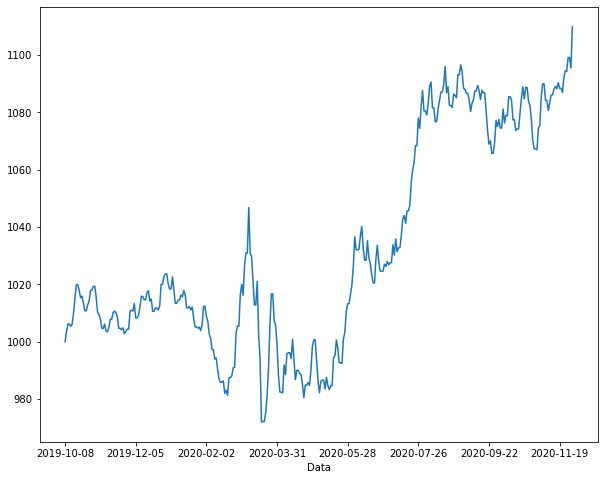

In [49]:
dfATR['Saldo'].plot(figsize=(10,8))

# Métricas ATR

In [50]:
dfATR['Retorno']=dfATR['Saldo'].pct_change()
dfATR['R. Acumulado'] = (1+dfATR['Retorno']).cumprod()
dfATR['Retorno'].iloc[0] = 0
dfATR['R. Acumulado'].iloc[0]=0

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [113]:
# Sharpe

Sharpe_ATR= (dfATR['Retorno'].mean()*(255-0.01))/(dfATR['Retorno'].std()*np.sqrt(255))
print(Sharpe_ATR)

1.0846492501742107


In [114]:
# Retorno anualizado
Retorno_anualizadoATR= (1+dfATR['Retorno'].sum())**0.5
print(Retorno_anualizadoATR)

1.0524714401536521


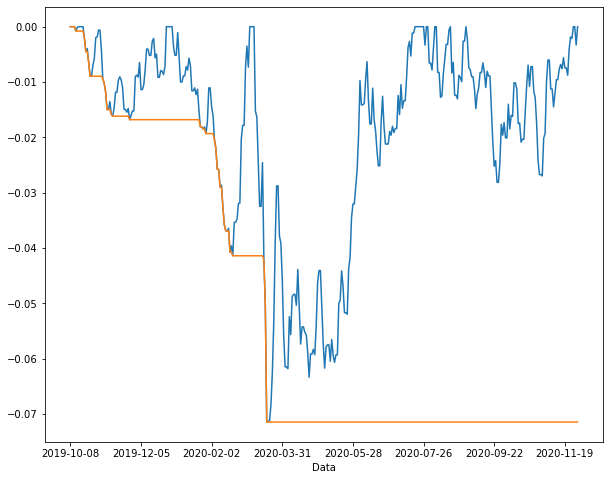

In [115]:
#MDD
Roll_Max2 = dfATR['Saldo'].cummax()
Daily_Drawdown2 = dfATR['Saldo']/Roll_Max2 - 1.0
MDDATR = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDATR.plot(figsize=(10,8))

In [116]:
MDDATR.min()

-0.07144631257164702

In [117]:
#Calmar
Calmar_ATR = (-dfATR['Retorno'].mean()*255)/MDDATR.min()
print(Calmar_ATR)

1.067721449310139


# Benchmark SAR

In [51]:
amostrasar = amostra

In [52]:
janela = 240
total=amostrasar.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosSar=[]
diasSar=[]
close=[]
sinal=[]
SAR=[]
yprice=[]
change=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostrasar.iloc[t:(janela)]
    inSample = amostrasar.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosSar.extend(inSample['body'])
    diasSar.extend(inSample.index)
    close.extend(inSample['Close'])
    SAR.extend(inSample['SAR'])
    
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [53]:
dfSAR = pd.DataFrame(diasSar)
dfSAR.columns=['Data']
dfSAR.set_index('Data', inplace = True)
dfSAR.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfSAR.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfSAR.insert(loc=2, column='SAR', value=SAR, allow_duplicates=False)


In [54]:
saldo=1000
for i in np.arange(1,len(diasSma)):
    if SAR[i]< close[i]:
        saldo=saldo +(dfSAR['Close'].iloc[i]-dfSAR['Close'].iloc[i-1])*1000
        dfSAR['Saldo'].iloc[i]=saldo
    else:
        saldo=saldo + (dfSAR['Close'].iloc[i-1]-dfSAR['Close'].iloc[i])*1000
        dfSAR['Saldo'].iloc[i]=saldo

In [122]:
dfSAR

,Saldo,Close,SAR
Data,,,
2019-10-08,1000.00,1.09710,1.088381
2019-10-09,1003.40,1.10050,1.088614
2019-10-10,1006.19,1.10329,1.089204
2019-10-11,1006.19,1.10329,1.090228
2019-10-13,1005.38,1.10248,1.091189
...,...,...,...
2020-11-25,1205.83,1.19127,1.180667
2020-11-26,1210.76,1.19620,1.182009
2020-11-27,1210.76,1.19620,1.183737


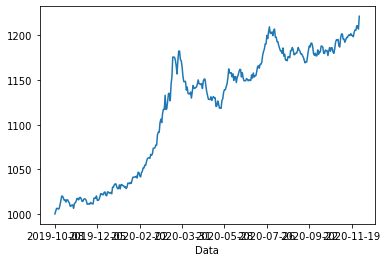

In [55]:
dfSAR['Saldo'].plot(fig=(10,8))

# Métrica de performance SAR

In [56]:
dfSAR['Retorno']=dfSAR['Saldo'].pct_change()
dfSAR['R. Acumulado'] = (1+dfSAR['Retorno']).cumprod()
dfSAR['Retorno'].iloc[0] = 0
dfSAR['R. Acumulado'].iloc[0]=0

In [57]:
# Sharpe

Sharpe_SAR= (dfSAR['Retorno'].mean()*(255-0.01))/(dfSAR['Retorno'].std()*np.sqrt(255))
print(Sharpe_SAR)

2.2818169632009306


In [126]:
# Retorno anualizado
Retorno_anualizadoSAR= (1+dfSAR['Retorno'].sum())**0.5
print(Retorno_anualizadoSAR)

1.096770722622627


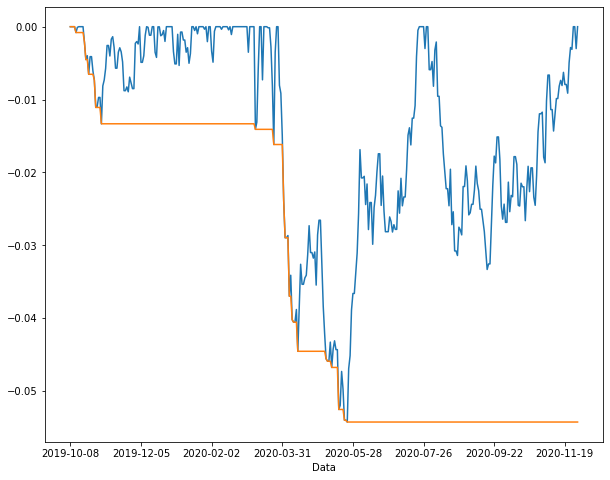

In [127]:
#MDD
Roll_Max2 = dfSAR['Saldo'].cummax()
Daily_Drawdown2 = dfSAR['Saldo']/Roll_Max2 - 1.0
MDDSAR = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDSAR.plot(figsize=(10,8))

In [128]:
MDDSAR.min()

-0.05425176540234267

In [129]:
#Calmar
Calmar_SAR = (-dfSAR['Retorno'].mean()*255)/MDDSAR.min()
print(Calmar_SAR)

2.6492243159087505


# Benchmark com CCI

In [58]:
amostraCCI=amostra

In [59]:
janela = 240
total=amostraCCI.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosCci=[]
diasCci=[]
close=[]
sinal=[]
CCI=[]
yprice=[]
change=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostraCCI.iloc[t:(janela)]
    inSample = amostraCCI.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosCci.extend(inSample['body'])
    diasCci.extend(inSample.index)
    close.extend(inSample['Close'])
    CCI.extend(inSample['CCI'])
    
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [60]:
dfCCI = pd.DataFrame(diasCci)
dfCCI.columns=['Data']
dfCCI.set_index('Data', inplace = True)
dfCCI.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfCCI.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfCCI.insert(loc=2, column='CCI', value=CCI, allow_duplicates=False)
dfCCI.insert(loc=3, column='flag',value=0,allow_duplicates=False)

In [61]:
saldo=1000
flag = 0
for i in np.arange(1,len(diasCci)):
    
    if CCI[i]>100:
        flag = 1
        dfCCI['flag'].iloc[i]= flag
    elif CCI[i] < -100:
        flag = -1
        dfCCI['flag'].iloc[i]= flag

    if flag ==1:
        saldo=saldo + (dfCCI['Close'].iloc[i]-dfCCI['Close'].iloc[i-1])*1000
        dfCCI['Saldo'].iloc[i]=saldo
    elif flag == -1:
        saldo=saldo + (dfCCI['Close'].iloc[i-1]-dfCCI['Close'].iloc[i])*1000
        dfCCI['Saldo'].iloc[i]=saldo
    elif flag==0:
        saldo=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


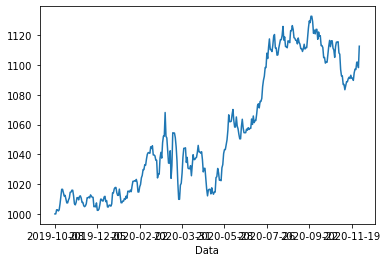

In [62]:
dfCCI['Saldo'].plot(fig=(10,8))

In [63]:
dfCCI

,Saldo,Close,CCI,flag
Data,,,,
2019-10-08,1000.00,1.09710,-13.842686,0
2019-10-09,1000.00,1.10050,58.596416,0
2019-10-10,1002.79,1.10329,123.181287,1
2019-10-11,1002.79,1.10329,129.048144,1
2019-10-13,1001.98,1.10248,115.490369,1
...,...,...,...,...
2020-11-25,1096.93,1.19127,143.362035,1
2020-11-26,1101.86,1.19620,209.232347,1
2020-11-27,1101.86,1.19620,210.113451,1


# Métricas CCI


In [135]:
dfCCI['Retorno']=dfCCI['Saldo'].pct_change()
dfCCI['R. Acumulado'] = (1+dfCCI['Retorno']).cumprod()
dfCCI['Retorno'].iloc[0] = 0
dfCCI['R. Acumulado'].iloc[0]=0

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [136]:
# Sharpe

Sharpe_CCI= (dfCCI['Retorno'].mean()*(255-0.01))/(dfCCI['Retorno'].std()*np.sqrt(255))
print(Sharpe_CCI)

1.13901603209886


In [137]:
# Retorno anualizado
Retorno_anualizadoCCI= (1+dfCCI['Retorno'].sum())**0.5
print(Retorno_anualizadoCCI)

1.0535604633848452


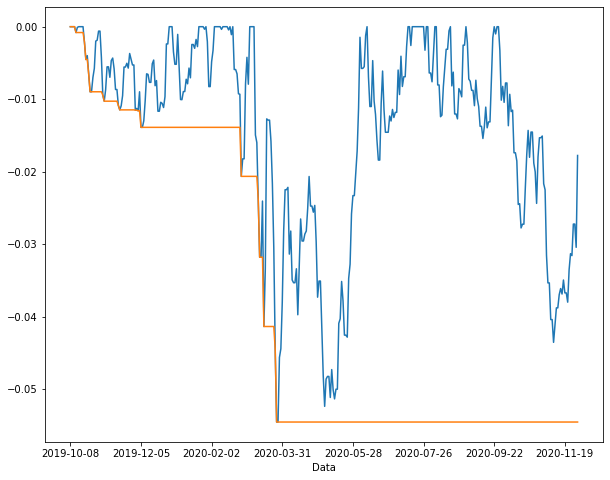

In [138]:
#MDD
Roll_Max2 = dfCCI['Saldo'].cummax()
Daily_Drawdown2 = dfCCI['Saldo']/Roll_Max2 - 1.0
MDDCCI = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDCCI.plot(figsize=(10,8))

In [139]:
MDDCCI.min()

-0.05455583851396917

In [140]:
#Calmar
Calmar_CCI= (-dfCCI['Retorno'].mean()*255)/MDDCCI.min()
print(Calmar_CCI)

1.4280659512210527


# Fazendo o benchmark com o MACD

# Arrumando os dias da amostra

In [108]:
#seguindo exemplo do tcc do andre, eu coloquei a amostra com valor de 600b
amostraMACD = amostra

# Calculando o MACD


In [109]:
# Calculando a EMA com período menor
ShortEMA = amostraMACD['Close'].ewm(span =12, adjust = False).mean()
# Calculando a EMA com período maior
LongEMA = amostraMACD['Close'].ewm(span = 26, adjust = False).mean()
# Calculando o sinal MACD
MACD = ShortEMA - LongEMA
# Calculando a linha do sinal
sinal = MACD.ewm(span = 9, adjust = False).mean()


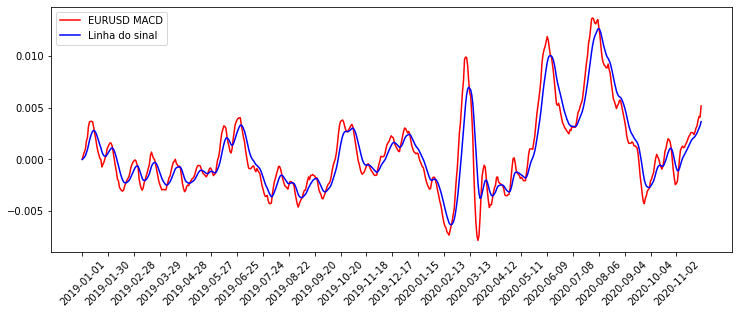

In [110]:
#plotando o gráfico
plt.figure(figsize = (12.2 , 4.5))
plt.plot(amostraMACD.index, MACD, label='EURUSD MACD', color = 'red')
plt.plot(amostraMACD.index, sinal, label = 'Linha do sinal', color = 'blue')
plt.xticks(amostraMACD.index[::25],rotation = 45)
plt.legend(loc='upper left')
plt.show()


# Adicionando a coluna com os valores do MACD no dataframe amostraMACD

In [111]:
amostraMACD['MACD'] = MACD
amostraMACD['Linha de Sinal'] = sinal
#visualizando os dados
amostraMACD.head()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce,MACD,Linha de Sinal
Gmt time,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1.14598,1.14967,1.13250,1.13432,444066.5465,-116.6,36.9,18.2,1.136605,1.138211,...,0.000000,-0.024048,-0.005732,-0.029641,0.005540,-0.024266,0.001784,1,0.000000,0.000000
2019-01-02,1.13423,1.14110,1.13092,1.13924,503259.7333,50.1,18.6,33.1,1.136537,1.138596,...,0.005188,-0.019815,0.000000,-0.019815,-0.005732,-0.025433,0.005540,1,0.000392,0.000078
2019-01-03,1.13924,1.14189,1.13456,1.13943,418205.8579,1.9,24.6,46.8,1.136476,1.138727,...,-0.001532,-0.024711,0.005188,-0.019651,0.000000,-0.019651,-0.005732,-1,0.000711,0.000205
2019-01-04,1.13943,1.13943,1.13943,1.13943,0.0000,0.0,0.0,0.0,1.136538,1.138918,...,0.000600,-0.023215,-0.001532,-0.024711,0.005188,-0.019651,0.000000,1,0.000952,0.000354
2019-01-06,1.13955,1.14826,1.13954,1.14740,365290.1607,78.5,8.6,0.1,1.136818,1.139766,...,0.008953,-0.016972,0.000600,-0.016382,-0.001532,-0.017889,0.005188,-1,0.001766,0.000637


In [112]:
amostraMACD['price yesterday'] = amostraMACD['Close'].shift(1)
amostraMACD['change'] = (amostraMACD['Close']/amostraMACD['price yesterday'])
# invested macd
amostraMACD['invested_MACD'] = [1 if amostraMACD.loc[i,'MACD'] > amostraMACD.loc[i,'Linha de Sinal'] else -1 for i in amostraMACD.index]
MACD=amostraMACD[amostraMACD['invested_MACD']==1]
amostraMACD['retorno']=np.cumprod(MACD['change'])


C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

# Criando a função que sinalizará a compra ou venda 

In [113]:
def buy_sell(sinal):
    buy = []
    sell = []
    flag = -1
    
    for i in range(0,len(sinal)):
        if sinal['MACD'][i] > sinal['Linha de Sinal'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append(sinal['Close'][i])
                flag = 1
            else:
                buy.append(np.nan)

        elif sinal['MACD'][i] < sinal['Linha de Sinal'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append(sinal['Close'][i])
                flag = 0
            else:
                sell.append(np.nan) 
        else:
            sell.append(np.nan)
            buy.append(np.nan)
    return (buy,sell)

In [114]:
# criando as colunas buy e sell
a = buy_sell(amostraMACD)
amostraMACD['Preço para Buy'] = a[0]
amostraMACD['Preço para Sell'] = a[1]

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


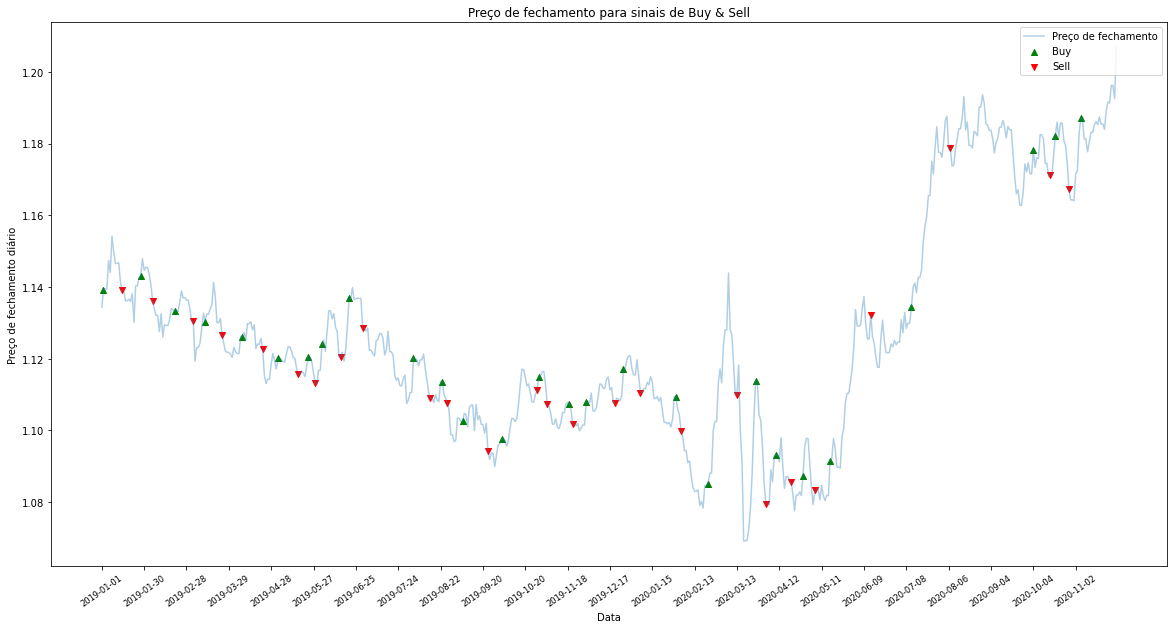

In [115]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
plt.scatter(amostraMACD.index, amostraMACD['Preço para Buy'], color = 'green', label = 'Buy', marker = '^', alpha=1)
plt.scatter(amostraMACD.index, amostraMACD['Preço para Sell'], color = 'red', label = 'Sell', marker = 'v', alpha=1)

plt.plot(amostraMACD['Close'], label='Preço de fechamento', alpha =0.35)
plt.title('Preço de fechamento para sinais de Buy & Sell')
plt.xticks(amostraMACD.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Preço de fechamento diário')
plt.legend( loc = 'upper right')
plt.show()

# Separando os dias de operações conforme o walkforward

In [116]:
janela = 240
total=amostraMACD.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward


In [117]:
#listas para receberem valores
pontosMacd=[]
diasMacd=[]
buy =[]
sell= []
close=[]
sinal=[]
MACDl=[]
yprice=[]
change=[]
invistedMACD=[]
retorno=[]

In [118]:
for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostraMACD.iloc[t:(janela)]
    inSample = amostraMACD.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosMacd.extend(inSample['body'])
    diasMacd.extend(inSample.index)
    buy.extend(inSample['Preço para Buy'])
    sell.extend(inSample['Preço para Sell'])
    close.extend(inSample['Close'])
    sinal.extend(inSample['Linha de Sinal'])  
    MACDl.extend(inSample['MACD'])
    yprice.extend(inSample['price yesterday'])
    change.extend(inSample['change'])
    invistedMACD.extend(inSample['invested_MACD'])
    retorno.extend(inSample['retorno'])
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [119]:
dfMACD = pd.DataFrame(diasMacd)
dfMACD.columns=['Data']
dfMACD.set_index('Data', inplace = True)
dfMACD.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfMACD.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfMACD.insert(loc=2, column='MACD', value=MACDl, allow_duplicates=False)
dfMACD.insert(loc=3, column='Linha de Sinal', value=sinal, allow_duplicates=False)
dfMACD.insert(loc=4, column='Buy', value=buy, allow_duplicates=False)
dfMACD.insert(loc=4, column='yesterday price', value=yprice, allow_duplicates=False)
dfMACD.insert(loc=5, column='change', value=change, allow_duplicates=False)
dfMACD.insert(loc=6, column='retorno', value=retorno, allow_duplicates=False)
dfMACD.insert(loc=7, column='invisted macd', value=invistedMACD, allow_duplicates=False)


In [120]:
saldo = 1000

In [121]:
dfMACD.head(50)

,Saldo,Close,MACD,Linha de Sinal,yesterday price,change,retorno,invisted macd,Buy
Data,,,,,,,,,
2019-10-08,1000,1.09710,-0.002097,-0.002641,1.09560,1.001369,1.004391,1,NaN
2019-10-09,1000,1.10050,-0.001631,-0.002439,1.09710,1.003099,1.007504,1,NaN
2019-10-10,1000,1.10329,-0.001025,-0.002156,1.10050,1.002535,1.010058,1,NaN
2019-10-11,1000,1.10329,-0.000539,-0.001833,1.10329,1.000000,1.010058,1,NaN
2019-10-13,1000,1.10248,-0.000217,-0.001510,1.10329,0.999266,1.009317,1,NaN
2019-10-14,1000,1.10320,0.000096,-0.001188,1.10248,1.000653,1.009976,1,NaN
2019-10-15,1000,1.10710,0.000651,-0.000821,1.10320,1.003535,1.013546,1,NaN
2019-10-16,1000,1.11234,0.001496,-0.000357,1.10710,1.004733,1.018343,1,NaN
2019-10-17,1000,1.11703,0.002516,0.000217,1.11234,1.004216,1.022637,1,NaN


In [122]:
for i in np.arange(1,len(diasMacd)):
    if invistedMACD[i]==1:
        saldo=(retorno[i]*1000)
        dfMACD['Saldo'].iloc[i]=saldo
    else:
        saldo=saldo + (dfMACD['yesterday price'].iloc[i]-dfMACD['Close'].iloc[i])*1000
        dfMACD['Saldo'].iloc[i]=saldo
       

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [123]:
dfMACD.head(50)


,Saldo,Close,MACD,Linha de Sinal,yesterday price,change,retorno,invisted macd,Buy
Data,,,,,,,,,
2019-10-08,1000.000000,1.09710,-0.002097,-0.002641,1.09560,1.001369,1.004391,1,NaN
2019-10-09,1007.504016,1.10050,-0.001631,-0.002439,1.09710,1.003099,1.007504,1,NaN
2019-10-10,1010.058252,1.10329,-0.001025,-0.002156,1.10050,1.002535,1.010058,1,NaN
2019-10-11,1010.058252,1.10329,-0.000539,-0.001833,1.10329,1.000000,1.010058,1,NaN
2019-10-13,1009.316699,1.10248,-0.000217,-0.001510,1.10329,0.999266,1.009317,1,NaN
2019-10-14,1009.975857,1.10320,0.000096,-0.001188,1.10248,1.000653,1.009976,1,NaN
2019-10-15,1013.546294,1.10710,0.000651,-0.000821,1.10320,1.003535,1.013546,1,NaN
2019-10-16,1018.343496,1.11234,0.001496,-0.000357,1.10710,1.004733,1.018343,1,NaN
2019-10-17,1022.637175,1.11703,0.002516,0.000217,1.11234,1.004216,1.022637,1,NaN


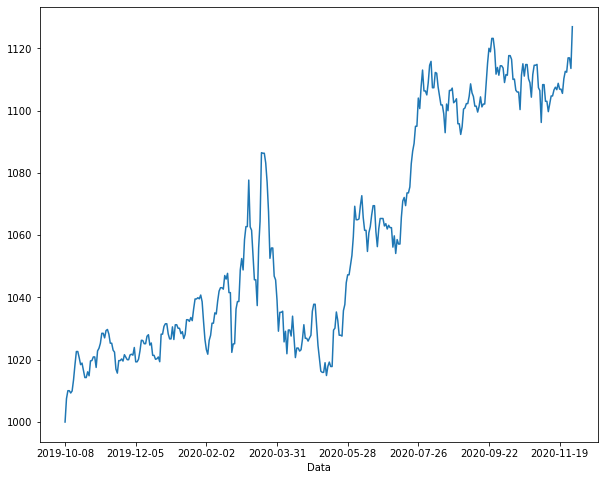

In [124]:
dfMACD['Saldo'].plot(figsize=(10,8))

In [125]:
#calculando o retorno
dfMACD['Retorno']=dfMACD['Saldo'].pct_change()
dfMACD['R. Acumulado'] = (dfMACD['Retorno']).cumprod()

In [126]:
dfMACD

,Saldo,Close,MACD,Linha de Sinal,yesterday price,change,retorno,invisted macd,Buy,Retorno,R. Acumulado
Data,,,,,,,,,,,
2019-10-08,1000.000000,1.09710,-0.002097,-0.002641,1.09560,1.001369,1.004391,1,NaN,NaN,NaN
2019-10-09,1007.504016,1.10050,-0.001631,-0.002439,1.09710,1.003099,1.007504,1,NaN,0.007504,0.007504
2019-10-10,1010.058252,1.10329,-0.001025,-0.002156,1.10050,1.002535,1.010058,1,NaN,0.002535,0.000019
2019-10-11,1010.058252,1.10329,-0.000539,-0.001833,1.10329,1.000000,1.010058,1,NaN,0.000000,0.000000
2019-10-13,1009.316699,1.10248,-0.000217,-0.001510,1.10329,0.999266,1.009317,1,NaN,-0.000734,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-25,1112.300870,1.19127,0.003237,0.002546,1.19157,0.999748,1.112301,1,NaN,-0.000252,0.000000
2020-11-26,1116.904061,1.19620,0.003771,0.002791,1.19127,1.004138,1.116904,1,NaN,0.004138,0.000000
2020-11-27,1116.904061,1.19620,0.004147,0.003062,1.19620,1.000000,1.116904,1,NaN,0.000000,0.000000


# Calculando as métricas de desempenho

# Índice de Sharpe

In [160]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio3 = (dfMACD['Retorno'].mean()*(255-0.01)) /(dfMACD['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio3)

1.2596735802551982


In [179]:
#Para anualizar o índice de sharpe podemos multiplicar pela raiz quadrada de 252
#que é o número de dias possíveis para day trade no ano
A_Sharpe_Ratio3 = (252**0.5) * Sharpe_Ratio3
print('Índice de Sharpe Anual: '+str(A_Sharpe_Ratio3))

Índice de Sharpe Anual: 19.996698158841706


# Retorno Anualizado

In [161]:
Retorno_anualizado3 = (1+dfMACD['Retorno'].sum())**0.5
print(Retorno_anualizado3)

1.059654906115253


# Máximo Drawdown

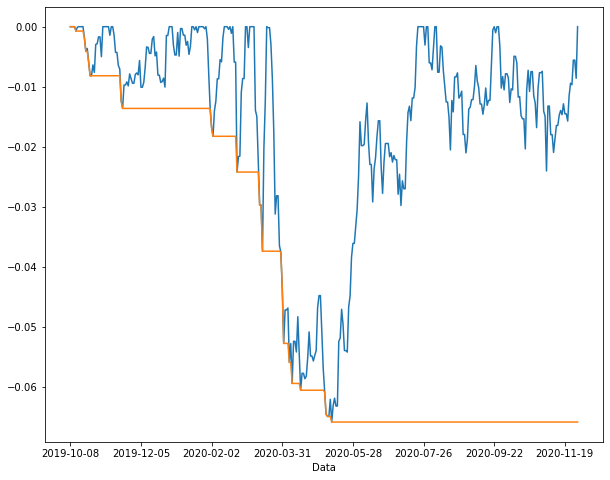

In [162]:
Roll_Max3 = dfMACD['Saldo'].cummax()
Daily_Drawdown3 = dfMACD['Saldo']/Roll_Max3 - 1.0
MDD3 = Daily_Drawdown3.cummin()
# Plotando o resultado
Daily_Drawdown3.plot(figsize =(10,8))
MDD3.plot(figsize=(10,8))

In [163]:
MDD3.min()

-0.06584592070880801

# Índice de Calmar

In [164]:
Calmar_Ratio3 = -(dfMACD['Retorno'].mean()*255)/MDD3.min()
print(Calmar_Ratio3)

1.3254321001954545


# Testando para SVM

# Primeiro utilizando o SVM sem o grid_search()

In [64]:
#fazendo os imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [65]:
amostra

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce,price yesterday,change,invested_SMA,retorno
Gmt time,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1.14598,1.14967,1.13250,1.13432,444066.5465,-116.6,36.9,18.2,1.136605,1.138211,...,-0.005732,-0.029641,0.005540,-0.024266,0.001784,1,NaN,NaN,1,NaN
2019-01-02,1.13423,1.14110,1.13092,1.13924,503259.7333,50.1,18.6,33.1,1.136537,1.138596,...,0.000000,-0.019815,-0.005732,-0.025433,0.005540,1,1.13432,1.004337,1,1.004337
2019-01-03,1.13924,1.14189,1.13456,1.13943,418205.8579,1.9,24.6,46.8,1.136476,1.138727,...,0.005188,-0.019651,0.000000,-0.019651,-0.005732,-1,1.13924,1.000167,1,1.004505
2019-01-04,1.13943,1.13943,1.13943,1.13943,0.0000,0.0,0.0,0.0,1.136538,1.138918,...,-0.001532,-0.024711,0.005188,-0.019651,0.000000,1,1.13943,1.000000,1,1.004505
2019-01-06,1.13955,1.14826,1.13954,1.14740,365290.1607,78.5,8.6,0.1,1.136818,1.139766,...,0.000600,-0.016382,-0.001532,-0.017889,0.005188,-1,1.13943,1.006995,1,1.011531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-25,1.19157,1.19409,1.18852,1.19127,309694.9060,-3.0,25.2,27.5,1.179062,1.184336,...,0.000000,0.010733,-0.007587,0.003065,0.001130,1,1.19157,0.999748,1,0.983202
2020-11-26,1.19125,1.19641,1.19068,1.19620,297590.7008,49.5,2.1,5.7,1.179544,1.185524,...,-0.004166,0.014916,0.000000,0.014916,-0.007587,-1,1.19127,1.004138,1,0.987271
2020-11-27,1.19620,1.19620,1.19620,1.19620,0.0000,0.0,0.0,0.0,1.179976,1.186200,...,0.000204,0.019161,-0.004166,0.014916,0.000000,-1,1.19620,1.000000,1,0.987271


In [72]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [73]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]

In [74]:
clf = make_pipeline(StandardScaler(), SVC(C= 1, gamma= 'auto', kernel= 'rbf'))

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #trocar o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    
    #faz a predição e coleta o valor
    clf.fit(X_treino,Y_treino)
    yrf_pred=clf.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)
    pontos.extend(X_teste['body'])
    predicoes.extend(yrf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    window= window+60
    
    print(acuracia)

0.5333333333333333
0.55
0.6
0.5
0.55
0.55


# Calculando os retornos

In [75]:
lucroSvm = pd.DataFrame(dias)
lucroSvm.columns=['Data']
lucroSvm.set_index('Data', inplace = True)
lucroSvm.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
lucroSvm.head()

,Saldo
Data,
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000
2019-10-13,1000


In [76]:
saldo =1000

In [77]:

for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs(pontos[i]*0.1)
        lucroSvm.iloc[i] = saldo
         
    else:
        saldo = saldo - abs(pontos[i]*0.1)
        lucroSvm.iloc[i] = saldo 

In [78]:
lucroSvm

,Saldo
Data,
2019-10-08,1000.00
2019-10-09,996.54
2019-10-10,999.34
2019-10-11,999.34
2019-10-13,998.66
...,...
2020-11-25,1188.35
2020-11-26,1193.30
2020-11-27,1193.30


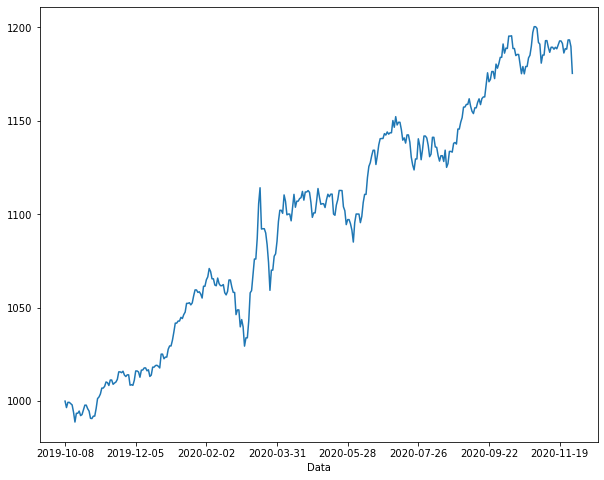

In [89]:
lucroSvm['Retorno']=lucroSvm['Saldo'].pct_change()
lucroSvm['R. Acumulado'] = (1+lucroSvm['Retorno']).cumprod()
lucroSvm['Retorno'].iloc[0] = 0
lucroSvm['R. Acumulado'].iloc[0]=0
lucroSvm['Saldo'].plot(figsize=(10,8))

In [69]:
lucroSvm.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

In [70]:
lucroSvm

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-08,-1,1000.00,0.000000,0.00000
2019-10-09,-1,996.54,-0.003460,0.99654
2019-10-10,-1,999.34,0.002810,0.99934
2019-10-11,-1,999.34,0.000000,0.99934
2019-10-13,-1,998.66,-0.000680,0.99866
...,...,...,...,...
2020-11-25,-1,1188.35,-0.000252,1.18835
2020-11-26,-1,1193.30,0.004165,1.19330
2020-11-27,-1,1193.30,0.000000,1.19330


# Métricas de desempenho


# Índice de Sharpe

In [71]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio4 =( lucroSvm['Retorno'].mean()*(255-0.01)) /(lucroSvm['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio4)

1.8009720367091349


# Retorno anualizado

In [72]:
Retorno_anualizado4 = (1+lucroSvm['Retorno'].sum())**0.5
print(Retorno_anualizado4)

1.0791642435872684


# Máximo Drawdown

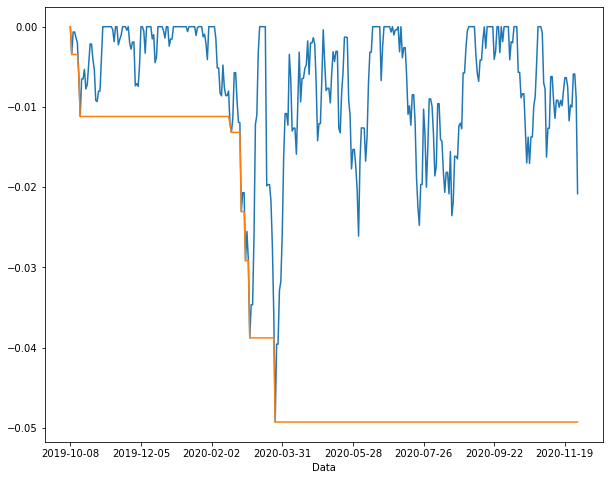

In [73]:
Roll_Max4 = lucroSvm['Saldo'].cummax()
Daily_Drawdown4 = lucroSvm['Saldo']/Roll_Max4 - 1.0
MDD4 = Daily_Drawdown4.cummin()
# Plotando o resultado
Daily_Drawdown4.plot(figsize =(10,8))
MDD4.plot(figsize=(10,8))

In [74]:
MDD4.min()

-0.04927346323338

# Índice de Calmar

In [75]:
Calmar_Ratio4 = -lucroSvm['Retorno'].mean()*255/MDD4.min()
print(Calmar_Ratio4)

2.366150996244402


# Testando SVM com grid_search a cada passo do WFA

In [80]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [81]:
C = [x for x in np.logspace(start = 2**-15, stop = 2**5)]
gamma =  [x for x in np.logspace(start = 2**-15, stop = 2**3)]

In [82]:
from sklearn.model_selection import GridSearchCV
# Criando a matriz de parametros
param_grid = {'C': C, 
              'gamma': gamma,
              'kernel': ['rbf']} 
# Instanciando o modelo de machine learning
clf = SVC()
# Instanciando o grid search
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [83]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #troca o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    #faz a predição e coleta o valor

    grid_search.fit(X_treino, Y_treino)
    clf_pred=grid_search.predict(X_teste)
    acuracia=accuracy_score(Y_teste, clf_pred)

    pontos.extend(X_teste['body'])
    predicoes.extend(clf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    
    window= window+60
    print(acuracia)
    print(grid_search.best_params_)

Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 4680 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   58.6s finished


0.5333333333333333
{'C': 1.0000702717894114, 'gamma': 29.47220758274401, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   43.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.65
{'C': 1.0000702717894114, 'gamma': 6.55169896108552, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   43.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.6
{'C': 1.0000702717894114, 'gamma': 6.55169896108552, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   43.4s finished


0.5
{'C': 1.0000702717894114, 'gamma': 6.55169896108552, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   43.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.55
{'C': 1.0000702717894114, 'gamma': 1.0000702717894114, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   28.6s


0.5666666666666667
{'C': 1.0000702717894114, 'gamma': 1.0000702717894114, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   43.1s finished


# Calculando os retornos

In [84]:
lucroSvmg = pd.DataFrame(dias)
lucroSvmg.columns=['Data']
lucroSvmg.set_index('Data', inplace = True)
lucroSvmg.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
lucroSvmg.head()

,Saldo
Data,
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000
2019-10-13,1000


In [85]:
saldo =1000
for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs(pontos[i]*0.1)
        lucroSvmg.iloc[i] = saldo
         
    else:
        saldo = saldo - abs(pontos[i]*0.1)
        lucroSvmg.iloc[i] = saldo 

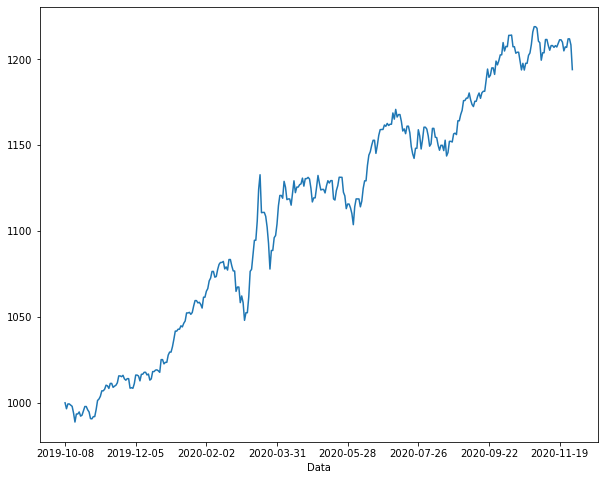

In [86]:
lucroSvmg['Retorno']=lucroSvmg['Saldo'].pct_change()
lucroSvmg['R. Acumulado'] = (1+lucroSvmg['Retorno']).cumprod()
lucroSvmg['Retorno'].iloc[0] = 0
lucroSvmg['R. Acumulado'].iloc[0]=0
lucroSvmg['Saldo'].plot(figsize=(10,8))

In [87]:
lucroSvmg.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

In [88]:
lucroSvmg

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-08,-1,1000.00,0.000000,0.00000
2019-10-09,-1,996.54,-0.003460,0.99654
2019-10-10,-1,999.34,0.002810,0.99934
2019-10-11,-1,999.34,0.000000,0.99934
2019-10-13,-1,998.66,-0.000680,0.99866
...,...,...,...,...
2020-11-25,-1,1206.93,-0.000249,1.20693
2020-11-26,-1,1211.88,0.004101,1.21188
2020-11-27,-1,1211.88,0.000000,1.21188


# Métricas de Desempenho

# Índice de Sharpe

In [85]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio5 = ((255-0.01)*lucroSvmg['Retorno'].mean()) /(lucroSvmg['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio5)

2.0040865871117415


In [92]:
#Para anualizar o índice de sharpe podemos multiplicar pela raiz quadrada de 252
#que é o número de dias possíveis para day trade no ano
A_Sharpe_Ratio5 = (252**0.5) * Sharpe_Ratio5
print('Índice de Sharpe Anual: '+str(A_Sharpe_Ratio5))

Índice de Sharpe Anual: 31.813888292027105


# Retorno Anualizado

In [86]:
Retorno_anualizado5 = (1+lucroSvmg['Retorno'].sum())**0.5
print(Retorno_anualizado5)

1.086366353854542


# Máximo Drawdown

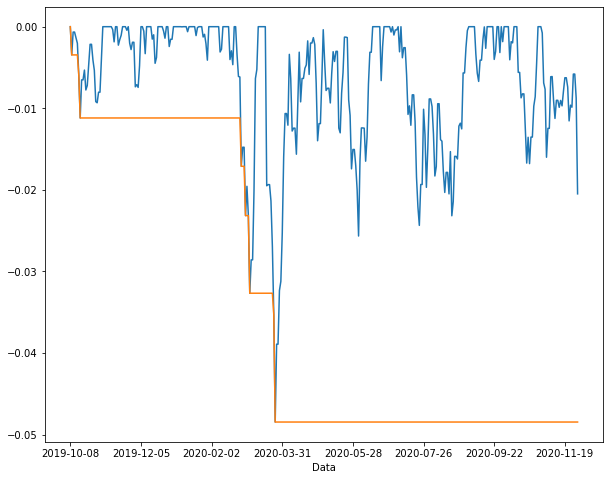

In [87]:
Roll_Max5 = lucroSvmg['Saldo'].cummax()
Daily_Drawdown5 = lucroSvmg['Saldo']/Roll_Max5 - 1.0
MDD5 = Daily_Drawdown5.cummin()
# Plotando o resultado
Daily_Drawdown5.plot(figsize =(10,8))
MDD5.plot(figsize=(10,8))

In [88]:
MDD5.min()

-0.04846526655896577

# Índice de Calmar

In [89]:
Calmar_Ratio5 = -(lucroSvmg['Retorno'].mean()*255)/MDD5.min()
print(Calmar_Ratio5)

2.6335540110081146


# Gráfico retornos

In [90]:
for i in np.arange(len(lucroSvmg)):
    if lucroSvmg['Ordem'].iloc[i] > 0:
        lucroSvmg['Ordem'].iloc[i]=lucroSvmg['Ordem'].iloc[i]+0.5
    else:
        lucroSvmg['Ordem'].iloc[i]=lucroSvmg['Ordem'].iloc[i]-0.5

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [91]:
for i in np.arange(len(lucroSvmg)):
    if lucro['Ordem'].iloc[i] > 0:
        lucro['Ordem'].iloc[i]=lucro['Ordem'].iloc[i]+0.3
    else:
        lucro['Ordem'].iloc[i]=lucro['Ordem'].iloc[i]-0.3

In [92]:
for i in np.arange(len(lucroSvmg)):
    if lucroWFA['Ordem'].iloc[i] > 0:
        lucroWFA['Ordem'].iloc[i]=lucroWFA['Ordem'].iloc[i]-0.5
    else:
        lucroWFA['Ordem'].iloc[i]=lucroWFA['Ordem'].iloc[i]+0.5

In [219]:
lucroSvmg

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-08,-1.5,1000.00,0.000000,0.00000
2019-10-09,-1.5,996.54,-0.003460,0.99654
2019-10-10,-1.5,999.34,0.002810,0.99934
2019-10-11,-1.5,999.34,0.000000,0.99934
2019-10-13,-1.5,998.66,-0.000680,0.99866
...,...,...,...,...
2020-11-25,-1.5,1206.93,-0.000249,1.20693
2020-11-26,-1.5,1211.88,0.004101,1.21188
2020-11-27,-1.5,1211.88,0.000000,1.21188


C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


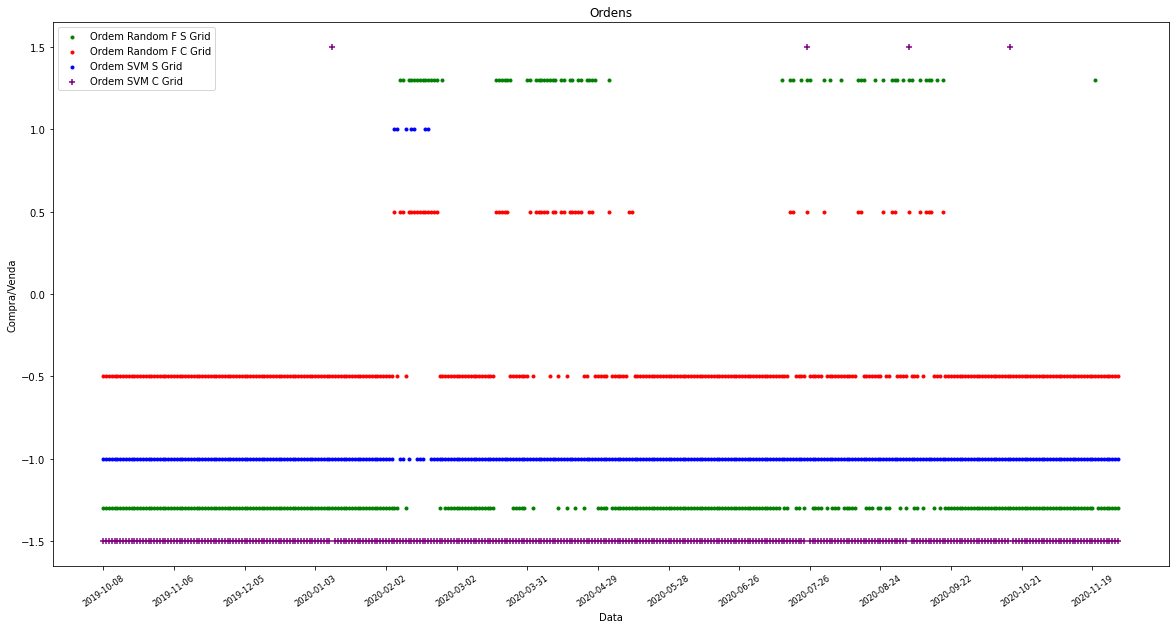

In [165]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
plt.scatter(lucroSvmg.index, lucroSvmg['Ordem'], color = 'purple', label = 'Ordem SVM C Grid', marker = '+', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

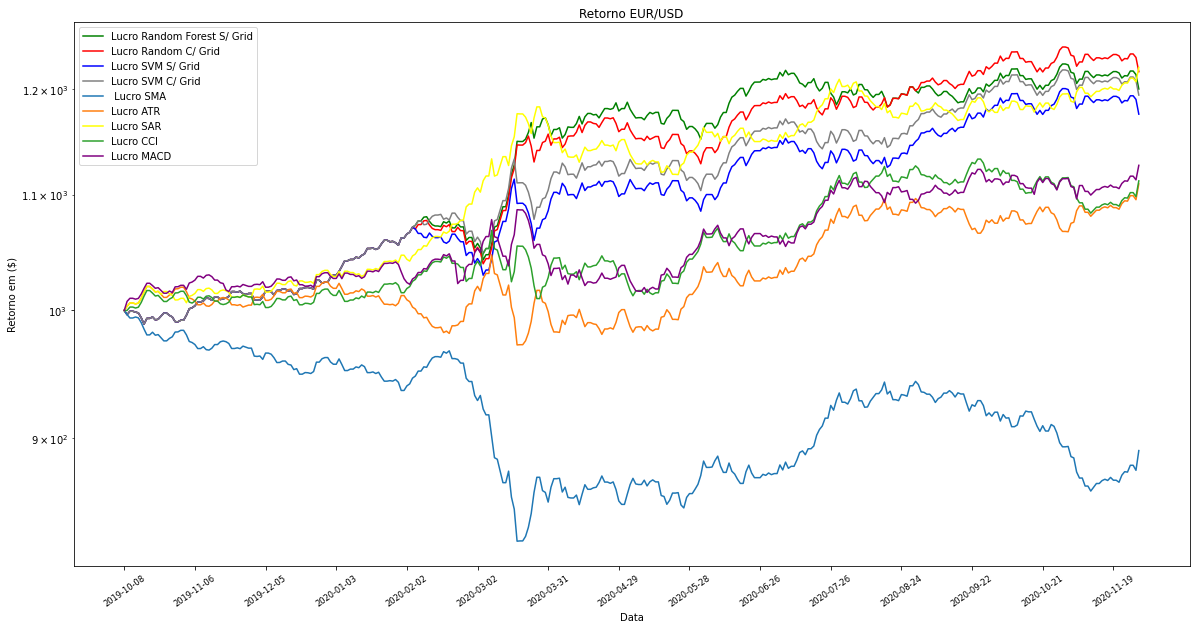

In [127]:
#Visualizando graficamente os retornos de cada estratégia
plt.figure(figsize= (20,10))
plt.plot(lucro.index, lucro['Saldo'], color = 'green', label = 'Lucro Random Forest S/ Grid', alpha=1)
plt.plot(lucroWFA.index, lucroWFA['Saldo'], color = 'red', label = 'Lucro Random C/ Grid', alpha=1)
plt.plot(lucroSvm.index, lucroSvm['Saldo'], color = 'blue', label = 'Lucro SVM S/ Grid', alpha=1)
plt.plot(lucroSvmg.index, lucroSvmg['Saldo'], color = 'gray', label = 'Lucro SVM C/ Grid', alpha=1)
plt.plot(dfSMA.index, dfSMA['Saldo'], label = ' Lucro SMA', alpha =1)
plt.plot(dfATR.index, dfATR['Saldo'], label = 'Lucro ATR', alpha = 1)
plt.plot(dfSAR.index, dfSAR['Saldo'], color='yellow', label = 'Lucro SAR', alpha =1)
plt.plot(dfCCI.index, dfCCI['Saldo'], label = 'Lucro CCI', alpha =1)
plt.plot(dfMACD['Saldo'], label='Lucro MACD',color='purple', alpha =1)
plt.title('Retorno EUR/USD')
plt.xticks(dfMACD.index[::25], size ='small', rotation=35 )
plt.yscale("log")
plt.xlabel('Data')
plt.ylabel('Retorno em ($)')
plt.legend( loc = 'upper left')
plt.show()

# Criando DataFrame com os índices

In [167]:
sharpe= [Sharpe_Ratio1,Sharpe_Ratio2,Sharpe_Ratio3,Sharpe_Ratio4,Sharpe_Ratio5, Sharpe_SMA, Sharpe_ATR, Sharpe_SAR, Sharpe_CCI]
calmar=[Calmar_Ratio1,Calmar_Ratio2,Calmar_Ratio3,Calmar_Ratio4,Calmar_Ratio5, Calmar_SMA, Calmar_ATR, Calmar_SAR, Calmar_CCI]
retornoa=[Retorno_anualizado1,Retorno_anualizado2,Retorno_anualizado3,Retorno_anualizado4,Retorno_anualizado5,Retorno_anualizadoSMA, Retorno_anualizadoATR, Retorno_anualizadoSAR,Retorno_anualizadoCCI]
estrategias=['Random Forest sem grid','Random Forest Com Grid','MACD','SVM sem grid','SVM com grid','SMA', 'ATR', 'SAR', 'CCI']
MDD=[MDD1.min(),MDD2.min(),MDD3.min(),MDD4.min(),MDD5.min(), MDDSMA.min(),MDDATR.min(),MDDSAR.min(),MDDCCI.min()]

In [168]:
dfRetorno=pd.DataFrame(estrategias)

In [169]:
dfRetorno.columns=['Estratégia']

In [170]:
dfRetorno.set_index('Estratégia', inplace=True)

In [171]:
dfRetorno.insert(loc=0, column='Sharpe', value=sharpe, allow_duplicates=False)
dfRetorno.insert(loc=1, column='Calmar', value=calmar, allow_duplicates=False)
dfRetorno.insert(loc=2, column='Retorno Anualizado', value=retornoa, allow_duplicates=False)
dfRetorno.insert(loc=3, column='Máximo DrawDown', value=MDD, allow_duplicates=False)

In [172]:
dfRetorno

,Sharpe,Calmar,Retorno Anualizado,Máximo DrawDown
Estratégia,,,,
Random Forest sem grid,2.100069,3.759519,1.088619,-0.034873
Random Forest Com Grid,2.254040,3.798619,1.095164,-0.037179
MACD,1.259674,1.325432,1.059655,-0.065846
SVM sem grid,1.800972,2.366151,1.079164,-0.049273
SVM com grid,2.004087,2.633554,1.086366,-0.048465
SMA,-0.968452,-0.453312,0.943016,-0.173010
ATR,1.084649,1.067721,1.052471,-0.071446
SAR,2.281817,2.649224,1.096771,-0.054252
CCI,1.139016,1.428066,1.053560,-0.054556
